In [10]:
# Load the Dataset using PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
spark = SparkSession.builder.appName("LoadCSV").getOrCreate()
edges_df = spark.read.csv("/content/edges.csv", header=True, inferSchema=True)
nodes_df = spark.read.csv("/content/nodes.csv", header=True, inferSchema=True)
edges_df.printSchema()
nodes_df.printSchema()
missing_values = nodes_df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in nodes_df.columns])
missing_values.show()
nodes_cleaned = nodes_df.na.drop()

root
 |-- id_0: string (nullable = true)
 |-- id_1: string (nullable = true)

root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- chart_hits: string (nullable = true)

+----------+----+---------+----------+------+----------+
|spotify_id|name|followers|popularity|genres|chart_hits|
+----------+----+---------+----------+------+----------+
|         0|   0|        4|         0|     0|    136724|
+----------+----+---------+----------+------+----------+



Number of nodes: 156303
Number of edges: 300386
Average Followers: 86224.26419762558
Average Popularity: 21.157497027272377


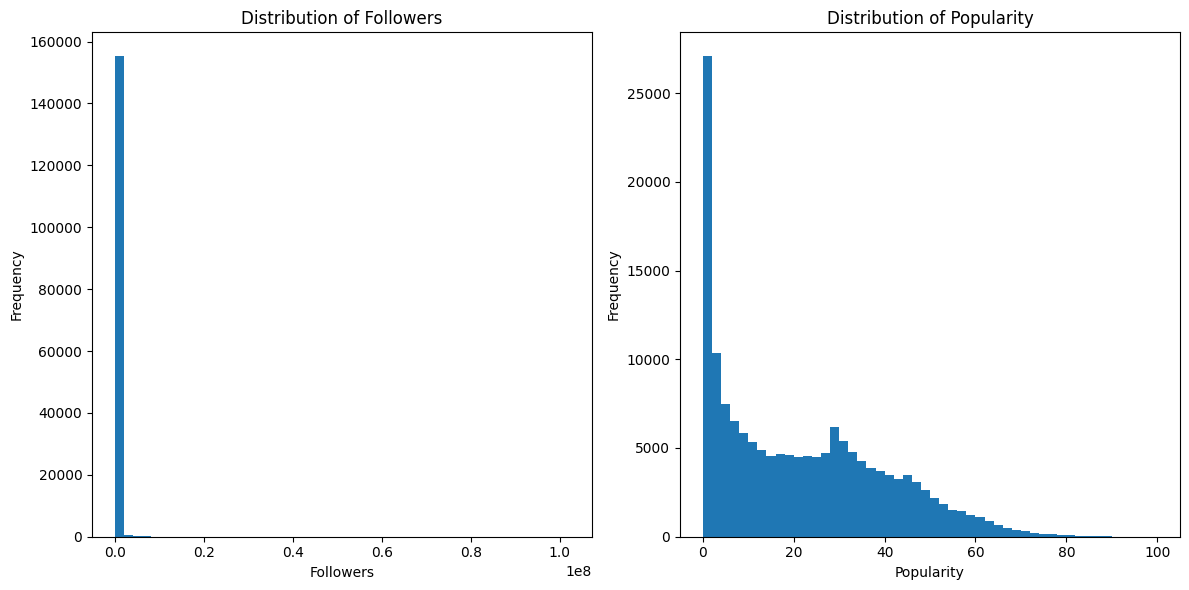

In [11]:
# Create the Graph using NetworkX
import networkx as nx
import pandas as pd
from pyspark.sql.functions import avg, col
import matplotlib.pyplot as plt
edges_pd_df = edges_df.toPandas()
nodes_cleaned = nodes_cleaned.toPandas()
G = nx.Graph()
for index, row in nodes_cleaned.iterrows():
    G.add_node(row['spotify_id'], name=row['name'], followers=row['followers'],
               popularity=row['popularity'], genres=row['genres'], chart_hits=row['chart_hits'])
for index, row in edges_pd_df.iterrows():
    G.add_edge(row['id_0'], row['id_1'])
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
# Calculate average followers and popularity and plot distributions
avg_followers = nodes_df.select(avg(col("followers").cast("double"))).collect()[0][0]
avg_popularity = nodes_df.select(avg("popularity")).collect()[0][0]
print(f"Average Followers: {avg_followers}")
print(f"Average Popularity: {avg_popularity}")
followers_pd = nodes_df.select(col("followers").cast("double").alias("followers")).toPandas()
popularity_pd = nodes_df.select("popularity").toPandas()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(followers_pd['followers'].dropna(), bins=50)
plt.title('Distribution of Followers')
plt.xlabel('Followers')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(popularity_pd['popularity'].dropna(), bins=50)
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


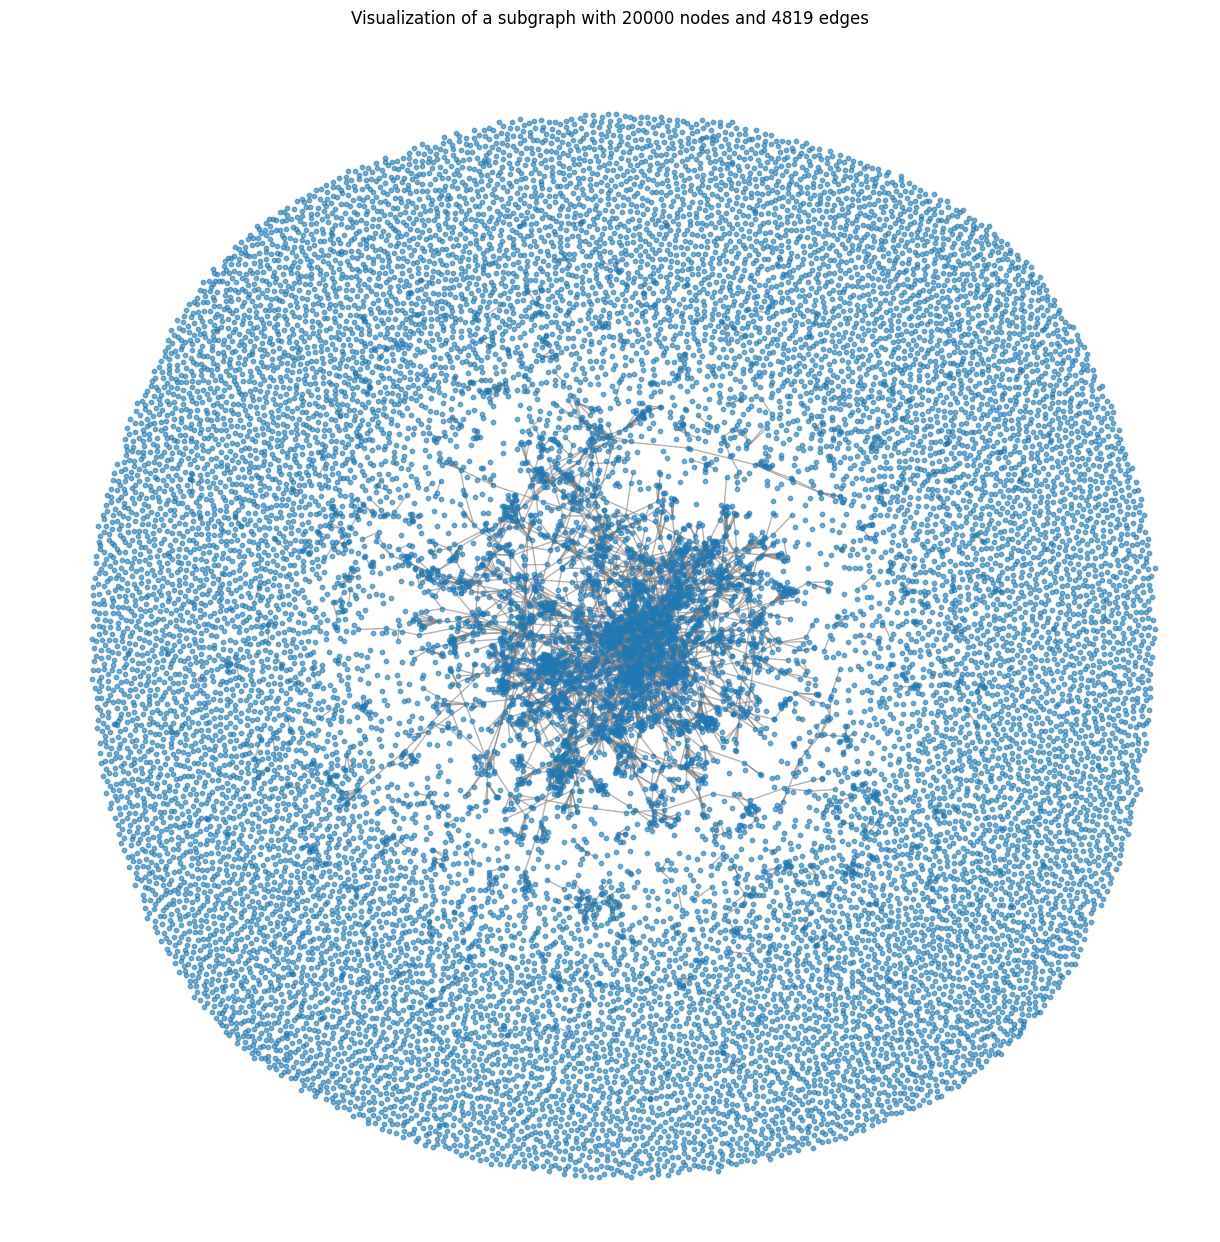

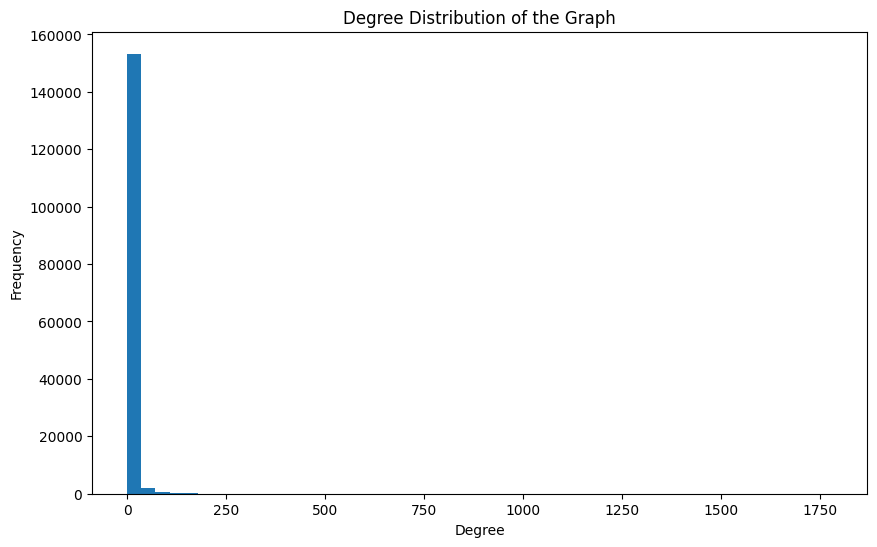

In [12]:
# Visualize the Graph (or a Subset) using NetworkX
import matplotlib.pyplot as plt
import random
num_nodes_to_analyze = 20000
if G.number_of_nodes() > num_nodes_to_analyze:
    nodes_to_analyze = random.sample(list(G.nodes()), num_nodes_to_analyze)
    subgraph = G.subgraph(nodes_to_analyze)
else:
    subgraph = G
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_size=10, edge_color='gray', alpha=0.6)
plt.title(f"Visualization of a subgraph with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")
plt.show()
# Plot degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=50)
plt.title("Degree Distribution of the Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [13]:
# Compute Network Properties
largest_component_subgraph = max(nx.connected_components(subgraph), key=len)
subgraph_largest_component = subgraph.subgraph(largest_component_subgraph)
diameter_lcc = nx.diameter(subgraph_largest_component)
print("Diameter:", diameter_lcc)
num_connected_components = nx.number_connected_components(subgraph)
edge_density = nx.density(subgraph)
print(f"Analysis on a subgraph with {subgraph.number_of_nodes()} nodes")
print(f"Network Diameter (Largest Connected Component of Subgraph): {diameter_lcc}")
print(f"Number of Connected Components (Subgraph): {num_connected_components}")
print(f"Edge Density (Subgraph): {edge_density}")
# Compute Centrality Measures
print("Centrality Measures:")
degree_centrality = nx.degree_centrality(subgraph)
betweenness_centrality = nx.betweenness_centrality(subgraph)
closeness_centrality = nx.closeness_centrality(subgraph)
eigenvector_centrality = nx.eigenvector_centrality(subgraph)
pagerank = nx.pagerank(subgraph)
# Identify Top 5 Most Influential Artists based on each centrality measure
def print_top_artists(centrality_dict, title, nodes_df_source=nodes_cleaned):
    sorted_artists = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)
    print(f"\nTop 5 Most Influential Artists by {title}:")
    for artist_id, centrality_value in sorted_artists[:5]:
        # Find the artist name using the nodes_cleaned DataFrame
        artist_info = nodes_df_source[nodes_df_source['spotify_id'] == artist_id]
        if not artist_info.empty:
            artist_name = artist_info['name'].iloc[0]
            print(f"- {artist_name}: {centrality_value:.4f}")
        else:
            print(f"- Artist with ID {artist_id} not found in DataFrame: {centrality_value:.4f}")
print_top_artists(degree_centrality, "Degree Centrality")
print_top_artists(betweenness_centrality, "Betweenness Centrality")
print_top_artists(closeness_centrality, "Closeness Centrality")
print_top_artists(eigenvector_centrality, "Eigenvector Centrality")
print_top_artists(pagerank, "PageRank")

Diameter: 21
Analysis on a subgraph with 20000 nodes
Network Diameter (Largest Connected Component of Subgraph): 21
Number of Connected Components (Subgraph): 15889
Edge Density (Subgraph): 2.4096204810240512e-05
Centrality Measures:

Top 5 Most Influential Artists by Degree Centrality:
- Steve Aoki: 0.0030
- Mc Rd: 0.0025
- Pitbull: 0.0024
- G. V. Prakash: 0.0018
- Bob Sinclar: 0.0017

Top 5 Most Influential Artists by Betweenness Centrality:
- Steve Aoki: 0.0029
- Konshens: 0.0027
- Pitbull: 0.0026
- Yellow Claw: 0.0018
- Wyclef Jean: 0.0017

Top 5 Most Influential Artists by Closeness Centrality:
- Pitbull: 0.0288
- Rick Ross: 0.0277
- R. Kelly: 0.0277
- Konshens: 0.0277
- Steve Aoki: 0.0276

Top 5 Most Influential Artists by Eigenvector Centrality:
- Pitbull: 0.3756
- Rick Ross: 0.2931
- Lil Wayne: 0.2845
- Ludacris: 0.2779
- R. Kelly: 0.2478

Top 5 Most Influential Artists by PageRank:
- Mc Rd: 0.0028
- Steve Aoki: 0.0028
- G. V. Prakash: 0.0021
- Pitbull: 0.0020
- Mastiksoul: 0.0

In [15]:
# Predict User Popularity using PySpark
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, sum, mean
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
# Convert centrality measures to Spark and assemble features
nodes_subset_df = nodes_df.select("spotify_id", "popularity", "followers")
degree_df = spark.createDataFrame([(k, float(v)) for k, v in degree_centrality.items()], ["spotify_id", "degree_centrality"])
betweenness_df = spark.createDataFrame([(k, float(v)) for k, v in betweenness_centrality.items()], ["spotify_id", "betweenness_centrality"])
closeness_df = spark.createDataFrame([(k, float(v)) for k, v in closeness_centrality.items()], ["spotify_id", "closeness_centrality"])
eigenvector_df = spark.createDataFrame([(k, float(v)) for k, v in eigenvector_centrality.items()], ["spotify_id", "eigenvector_centrality"])
pagerank_df = spark.createDataFrame([(k, float(v)) for k, v in pagerank.items()], ["spotify_id", "pagerank"])
merged_df = nodes_subset_df.join(degree_df, on="spotify_id", how="left")
merged_df = merged_df.join(betweenness_df, on="spotify_id", how="left")
merged_df = merged_df.join(closeness_df, on="spotify_id", how="left")
merged_df = merged_df.join(eigenvector_df, on="spotify_id", how="left")
merged_df = merged_df.join(pagerank_df, on="spotify_id", how="left")
analysis_df = merged_df.withColumn("popularity", col("popularity").cast(DoubleType()))
analysis_df = analysis_df.withColumn("followers", col("followers").cast(DoubleType()))
# Handle potential null values in centrality measures and popularity after join and cast
centrality_columns = ["degree_centrality", "betweenness_centrality", "closeness_centrality", "eigenvector_centrality", "pagerank"]
analysis_df = analysis_df.na.fill(0, subset=centrality_columns)
median_popularity = analysis_df.approxQuantile("popularity", [0.5], 0.01)[0]
analysis_df = analysis_df.na.fill(median_popularity, subset=["popularity"])
median_followers = analysis_df.approxQuantile("followers", [0.5], 0.01)[0]
analysis_df = analysis_df.na.fill(median_followers, subset=["followers"])
feature_columns = ['followers', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
analysis_df = assembler.transform(analysis_df)
# Split the data and build the Linear Regression model
training_data, testing_data = analysis_df.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="features", labelCol="popularity")
lr_model = lr.fit(training_data)
print("Model Coefficients:", lr_model.coefficients)
print("Model Intercept:", lr_model.intercept)
predictions = lr_model.transform(testing_data)
rmse_evaluator = RegressionEvaluator(labelCol="popularity", predictionCol="prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
r2_evaluator = RegressionEvaluator(labelCol="popularity", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on testing data: {rmse}")
print(f"R-squared (R2) on testing data: {r2}")

Model Coefficients: [4.1786560522752e-06,101744.76491434364,-31504.537481901938,376.9430581403637,-237.26754110410045,-31225.412205500183]
Model Intercept: 20.591872477977127
Root Mean Squared Error (RMSE) on testing data: 17.650296540014057
R-squared (R2) on testing data: 0.0754981262205815


Silhouette score for k=2: 0.9950998412465789
Silhouette score for k=3: 0.9696564964709191
Silhouette score for k=4: 0.9742687142001283
Silhouette score for k=5: 0.9798744066595141
Silhouette score for k=6: 0.9813258447893114
Silhouette score for k=7: 0.9813962075899809
Silhouette score for k=8: 0.9822628330068706
Silhouette score for k=9: 0.9818069842852305
Silhouette score for k=10: 0.9695569067314374


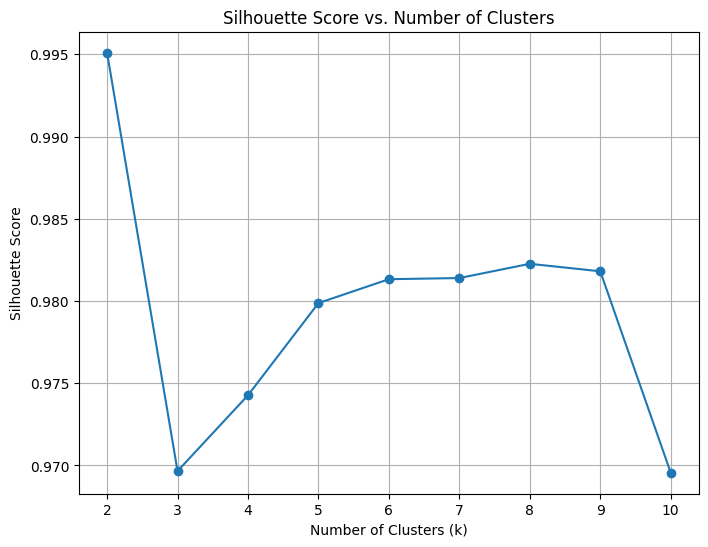

Optimal number of clusters based on Silhouette Score: {2}


In [16]:
# Cluster users based on their characteristics using PySpark
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
feature_columns = ['followers', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(analysis_df)
analysis_df_scaled = scaler_model.transform(analysis_df)
silhouette_scores = []
# Find K-Values
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
    model = kmeans.fit(analysis_df_scaled)
    predictions = model.transform(analysis_df_scaled)
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="prediction", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"Silhouette score for k={k}: {silhouette}")
# Plot silhouette scores to find the optimal k
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()
# Find optimal number of clusters
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters based on Silhouette Score:", {optimal_k})